In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import seaborn as sns
sns.set()

In [12]:
def get_mean_and_std(fpr_lists):
    fpr_all = []
    # fpr_all = np.empty(0, len(len(fpr_lists[0]) ))
    for fpr_list in fpr_lists:
        # print([*fpr_list.values()])
        fpr_all.append([fpr_list])
        # fpr_all = np.concatenate((fpr_all, ))
    fpr_all = np.array(fpr_all)
    # print(fpr_all)
    return fpr_all.mean(axis = 0).squeeze(), fpr_all.std(axis = 0).squeeze()

In [3]:
knn_fprs = {
    "sun": [0.76,22.04,45.92,79.57],
    "places365": [2.14,13.54,34.34,69.48],
    "dtd": [0.59,29.68, 39.4,70.66],
    "inaturalist": [1.21,34.87,34.82,92.68]
}

mip_fprs = {
    "sun": [4.87, 12.38,12.78,25.05],
    "places365": [2.78,12.29,14.19,24.91],
    "dtd": [1,12.89,14.24,33.68],
    "inaturalist": [0.36,5.97,3.72,15.23]
}




[ 1.175  25.0325 38.62   78.0975]
[0.60143578 8.05307822 4.65448171 9.27894492]


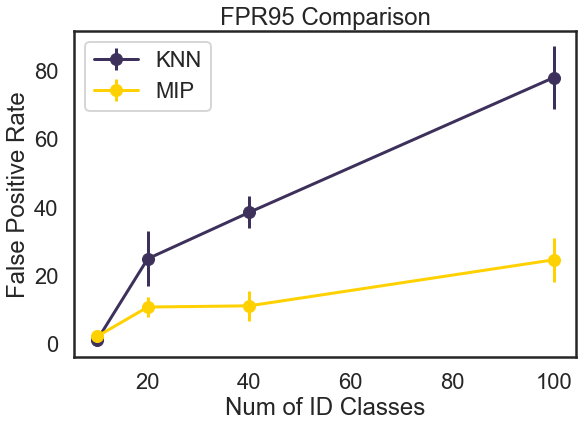

In [21]:
from matplotlib.colors import ListedColormap
cmap3 = ["#3D315B", "#8189B1", "#708B75", "#9AB87A", "#D2D50B", "#FFD100" ]
# plt.style.use('ggplot')
with sns.axes_style("white"):
    sns.set_context("poster")
    fig, (ax1) = plt.subplots(1, 1, figsize = (9, 6))

    ax1.set_xlabel("Num of ID Classes")
    ax1.set_ylabel("False Positive Rate")
    knn_fpr_mean, knn_fpr_std = get_mean_and_std([knn_fprs["sun"],knn_fprs["places365"],knn_fprs["dtd"],knn_fprs["inaturalist"]])
    mip_fpr_mean, mip_fpr_std = get_mean_and_std([mip_fprs["sun"],mip_fprs["places365"],mip_fprs["dtd"],mip_fprs["inaturalist"]])
    x = [10,20,40,100]
    print(knn_fpr_mean)
    print(knn_fpr_std)
    # ax1.set_xlim(-0.05, 4.05)
    #ax1.set_ylim(2, 8)
    ax1.errorbar(x,knn_fpr_mean, knn_fpr_std, fmt = "-o", label = "KNN", color = cmap3[0])
    ax1.errorbar(x,mip_fpr_mean, mip_fpr_std, fmt = "-o",label = "MIP", color = cmap3[5])
    ax1.set_title("FPR95 Comparison")
    ax1.legend()
    fig.savefig("fpr.pdf", bbox_inches = 'tight',pad_inches = 0)
    

                         FPR95     AUROC      AUPR
num_cls dataset                                   
100     AVG           7.476384  0.887344  0.881692
        SUN          10.082652  1.159849  1.346336
        dtd           3.862040  0.684010  0.770240
        iNaturalist   7.637674  0.929231  0.979474
        places365     9.363329  1.220012  1.370595
200     AVG           3.858462  0.769305  0.640570
        SUN           6.855795  0.990338  0.950431
        dtd           4.046335  1.176236  0.781761
        iNaturalist  10.198621  1.854872  1.632565
        places365     5.952157  0.844139  0.681454
400     AVG           3.368274  0.616093  0.306317
        SUN           4.581471  0.724590  0.391242
        dtd           3.269353  0.873739  0.375673
        iNaturalist  11.952913  2.248695  1.176380
        places365     3.977025  0.761564  0.416329
600     AVG           2.435379  0.435855  0.170235
        SUN           3.185126  0.592765  0.228145
        dtd           1.936874 

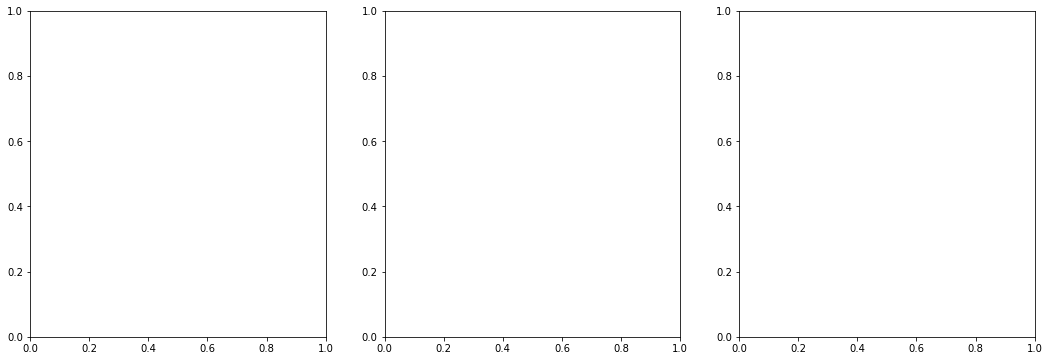

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

# num_cls = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_cls = [100, 200, 400, 600, 800, 1000]
# num_cls = [100, 500]
mean_list = []
var_list = []
trials = 5

for c in num_cls:
    df_list = []
    for exp_num in range(trials):
        # c_str = '' if c == 1000 else str(c)
        data_temp = {}
        name = f'imagenet-subset-exp{exp_num}'
        class_list_loc = f'./results/ImageNet{str(c)}/MIP/CLIP_ViT-L/14_T_0.1_ID_{name}_normalize_False/{name}.csv'
        if not os.path.exists(class_list_loc):
            print('did not find', c, exp_num)
            exit = os.system(f'python eval_ood_detection.py --score="MIP" --CLIP_ckpt="ViT-L/14" --gpu=4 --server="galaxy-01" --in_dataset="ImageNet-subset" --model="CLIP" --feat_dim=768 --batch-size=250 --T=0.1 --num_imagenet_cls={c} --name=imagenet-subset-exp{exp_num} --seed={exp_num}')
            if (exit > 0): quit()
        df = pd.read_csv(class_list_loc, index_col=0)
        df_list.append(df)
    df = pd.concat(df_list, keys=list(range(trials)), names=['trials', 'dataset'])
    var = df.groupby(level=1).std()
    mean = df.groupby(level=1).mean()
    var_list.append(var)
    mean_list.append(mean)

mean_df = pd.concat(mean_list, keys=num_cls, names=['num_cls'])
var_df = pd.concat(var_list, keys=num_cls, names=['num_cls'])
stats = mean_df.axes[1]
datasets = mean_df.index.levels[1]
print(var_df.head())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


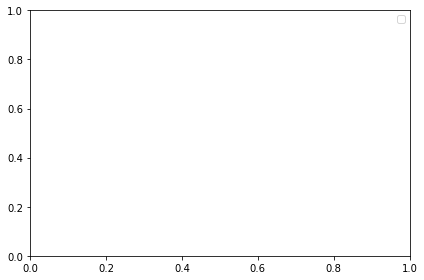

In [2]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
for i, score in enumerate(stats):
    for dataset in datasets:
        mean = mean_df.loc[(slice(None), dataset), score].values
        var = var_df.loc[(slice(None), dataset), score].values
        axs[i].errorbar(num_cls, mean, yerr=var, label=dataset)
        axs[i].set_title(score)
plt.legend()
plt.tight_layout()
plt.savefig('imagenet_subset.png')
